# 自动站slq语句计算数据的代码

In [ ]:
# func

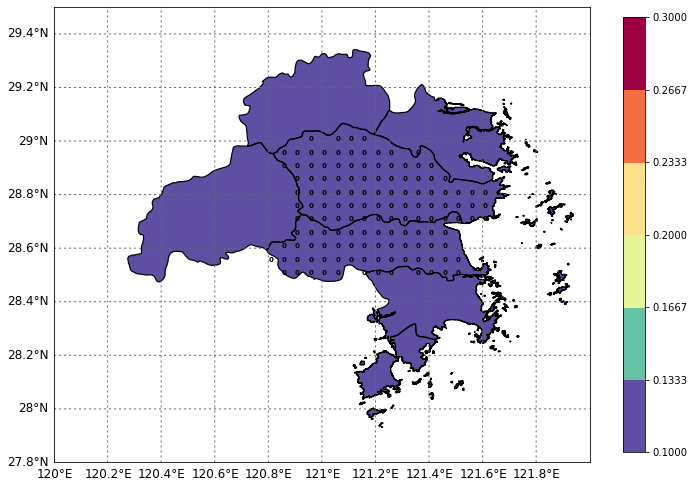

In [7]:
#coding=utf-8
from scipy.interpolate import griddata
import matplotlib as mpl
from math import ceil, floor
from rasterio import features
from affine import Affine
import numpy as np
import xarray as xr
import pandas as pd
import os
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
# from osgeo import gdal
import cartopy.crs as ccrs
import shapefile
from matplotlib.font_manager import FontProperties
# import netCDF4 as nc
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
from math import isnan
import geopandas as gpd
from ncmaps import Cmaps
# print("666")
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='lon', latitude='lat')

    return xr_da


def basemask(cs, ax, map, shpfile):

    sf = shapefile.Reader(shpfile)
    vertices = []
    codes = []
    for shape_rec in sf.shapeRecords():
        if shape_rec.record[0] >= 0:  
            pts = shape_rec.shape.points
            prt = list(shape_rec.shape.parts) + [len(pts)]
            for i in range(len(prt) - 1):
                for j in range(prt[i], prt[i+1]):
                    vertices.append(map(pts[j][0], pts[j][1]))
                codes += [Path.MOVETO]
                codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                codes += [Path.CLOSEPOLY]
            clip = Path(vertices, codes)
            clip = PathPatch(clip, transform = ax.transData)    
    for contour in cs.collections:
        contour.set_clip_path(clip)    



def makedegreelabel(degreelist):
    labels=[str(x)+u'°E' for x in degreelist]
    return labels


def plot_image(lat,lon,value):
    #线性插值
    N = len(value)
    a = []
    b = []
    z = []
    for i in range(N):
        if value[i]!=-9999.0:
            a.append(round(lon[i],2))
            b.append(round(lat[i],2))
            z.append(round(value[i],2))
    lat = np.array(b)
    lon = np.array(a)
    Zi = np.array(z)
    data_max = max(Zi)
    data_min = min(Zi)
    np.set_printoptions(precision = 2)
    x = np.arange(120.0,122.0,0.05)
    #print(x)
    y = np.arange(27.8,29.5,0.05)
    nx0 =len(x)
    ny0 =len(y)
    X, Y = np.meshgrid(x, y)#100*100
    P = np.array([X.flatten(), Y.flatten() ]).transpose()    
    Pi =  np.array([lon, lat ]).transpose()
    Z_linear = griddata(Pi, Zi, P, method = "nearest").reshape([ny0,nx0])
    #绘图
    levels = np.linspace(start = data_min/10.0, stop = data_max/10.0, num = 7)
    self_define_list = [130,144,155,170,185,200,225,235,240,244]
    rgb_file = 'ncl_default'
    #以下是核心api,实质为调用Cmaps基类的listmap()方法
    cmaps = Cmaps('ncl_default',self_define_list).listmap()
    # plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=[12,16]) 
    
    ax = fig.add_subplot(111)
    # plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
    filepath = "shpfile/"
    data_xr = xr.DataArray(Z_linear/10.0, coords=[ y,x], 
                        dims=["lat", "lon"])
    shp_da = add_shape_coord_from_data_array(data_xr, filepath+"taizhou.shp", "test")
    awash_da = shp_da.where(shp_da.test<2, other=np.nan)
    m = Basemap(llcrnrlon=120.0,llcrnrlat=27.8,urcrnrlon=122,urcrnrlat=29.5,resolution = None, projection = 'cyl')
    # 设置colorbar
    cbar_kwargs = {'shrink': 0.5}    
    cs = data_xr.plot.contourf(ax=ax, cmap='Spectral_r',levels =levels,cbar_kwargs=cbar_kwargs,add_labels=False)
    m.readshapefile(filepath+'taizhou','taizhou',color='k',linewidth=1.2)
    parallels = np.arange(27.8,29.5,0.2)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,True,False],color='dimgrey',dashes=[2, 3],fontsize= 12)  # ha= 'right'
    meridians = np.arange(120.0,122.0,0.2)
    m.drawmeridians(meridians,labels=[False,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 12)
    len_lat = len(data_xr.lat.data)
    len_lon = len(data_xr.lon.data)
    for i in range(len_lon-1):
        for j in range(len_lat-1):
            y0 = round(27.8+j*0.05,2)
            x0 = round(120.0+i*0.05,2)
            if not isnan(awash_da.data[j,i]):
                plt.text(x0,y0,str(int(awash_da.data[j,i])),fontsize= 7,fontweight = 800 ,color ="black")
    basemask(cs, ax, m, filepath+'taizhou')  

# 代码的核心计算脑
lat = [28,27,26.5]
lon = [121,122,122.5]
value = [1,2,3]
plot_image(lat,lon,value)

# 读取geopands

In [6]:
#coding=utf-8

#read region shp
path =  "shpfile/"
lake_gdf = gpd.read_file(os.path.join(path,'taizhou_village.shp'), encoding='utf8')
# region = lake_gdf[lake_gdf.name == 'Great Slave Lake']
lake_gdf

# def return_village():
#     pass


# def return_county():
#     pass


,geom,省,市,县,name,geometry
0,SRID=4326;MULTIPOLYGON(((120.621444122157 28.5...,浙江省,台州市,仙居县,淡竹乡,"POLYGON ((120.48949 28.58048, 120.49037 28.580..."
1,SRID=4326;MULTIPOLYGON(((120.410874722786 28.6...,浙江省,台州市,仙居县,湫山乡,"POLYGON ((120.35730 28.62710, 120.35724 28.627..."
2,SRID=4326;MULTIPOLYGON(((121.21496100751 28.89...,浙江省,台州市,临海市,大田街道,"POLYGON ((121.12093 28.92349, 121.12096 28.924..."
3,SRID=4326;MULTIPOLYGON(((121.166725696356 28.8...,浙江省,台州市,临海市,江南街道,"POLYGON ((121.14447 28.74706, 121.14373 28.747..."
4,SRID=4326;MULTIPOLYGON(((120.947388140005 28.9...,浙江省,台州市,临海市,白水洋镇,"POLYGON ((120.90843 28.84583, 120.90847 28.845..."
...,...,...,...,...,...,...
133,SRID=4326;MULTIPOLYGON(((121.256729600167 28.6...,浙江省,台州市,黄岩区,北城街道,"POLYGON ((121.25567 28.66359, 121.25454 28.661..."
134,SRID=4326;MULTIPOLYGON(((121.277769805229 28.6...,浙江省,台州市,黄岩区,南城街道,"POLYGON ((121.28785 28.63537, 121.28815 28.635..."
135,SRID=4326;MULTIPOLYGON(((121.223042284754 28.6...,浙江省,台州市,黄岩区,新前街道,"POLYGON ((121.22972 28.66074, 121.23089 28.658..."
136,SRID=4326;MULTIPOLYGON(((121.256379000147 28.6...,浙江省,台州市,黄岩区,西城街道,"POLYGON ((121.24174 28.61029, 121.24121 28.610..."


# 测试数据的可靠性

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


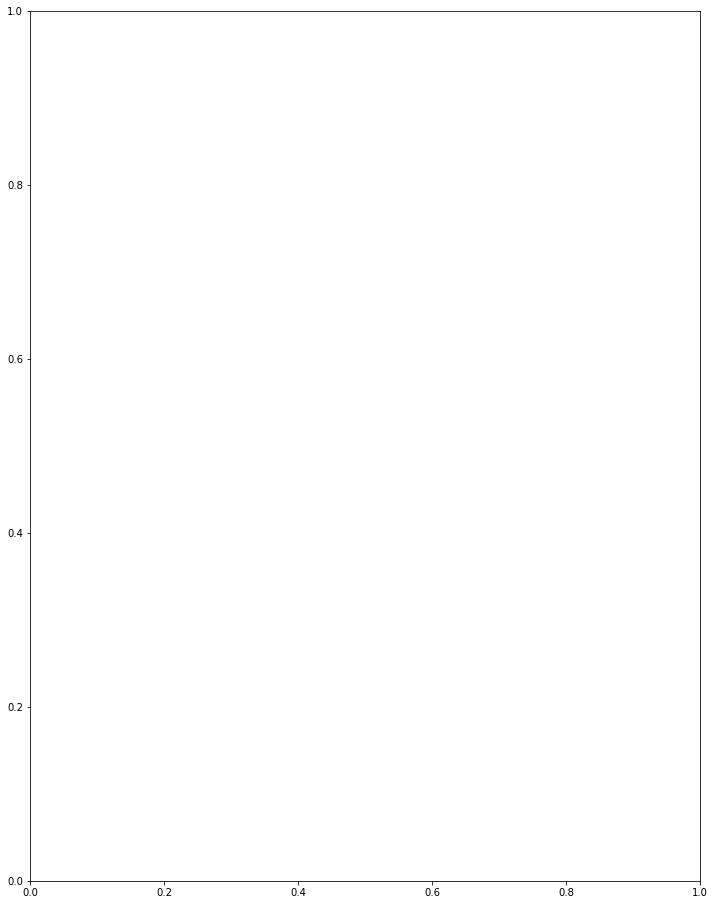

In [2]:
#coding=utf-8
from scipy.interpolate import griddata
import matplotlib as mpl
from math import ceil, floor
from rasterio import features
from affine import Affine
import numpy as np
import xarray as xr
import pandas as pd
import os
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
# from osgeo import gdal
import cartopy.crs as ccrs
import shapefile
from matplotlib.font_manager import FontProperties
# import netCDF4 as nc
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
from math import isnan
import geopandas as gpd
from ncmaps import Cmaps

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path, encoding='utf8')

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='lon', latitude='lat')

    return xr_da


def geo_single(xr_da, shp_path):
    '''用于返回数据的面雨量data'''
    data = {
        '上镇乡':15.3
    }
    filepath = "shpfile/"
    # geo_file = gpd.read_file(os.path.join(path,'taizhou_village.shp'), encoding='utf8')
    # 数据wash
    shp_da = add_shape_coord_from_data_array(xr_da, filepath+"taizhou_village.shp", "test")
    # 滤波数据
    awash_da = shp_da.where(shp_da.test<2, other=np.nan)   
    return data
    
    


def basemask(cs, ax, map, shpfile):

    sf = shapefile.Reader(shpfile)
    vertices = []
    codes = []
    for shape_rec in sf.shapeRecords():
        if shape_rec.record[0] >= 0:  
            pts = shape_rec.shape.points
            prt = list(shape_rec.shape.parts) + [len(pts)]
            for i in range(len(prt) - 1):
                for j in range(prt[i], prt[i+1]):
                    vertices.append(map(pts[j][0], pts[j][1]))
                codes += [Path.MOVETO]
                codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                codes += [Path.CLOSEPOLY]
            clip = Path(vertices, codes)
            clip = PathPatch(clip, transform = ax.transData)    
    for contour in cs.collections:
        contour.set_clip_path(clip)    



def makedegreelabel(degreelist):
    labels=[str(x)+u'°E' for x in degreelist]
    return labels


def plot_image(lat,lon,value):
    #线性插值
    N = len(value)
    a = []
    b = []
    z = []
    for i in range(N):
        if value[i]!=-9999.0:
            a.append(round(lon[i],2))
            b.append(round(lat[i],2))
            z.append(round(value[i],2))
    lat = np.array(b)
    lon = np.array(a)
    Zi = np.array(z)
    data_max = max(Zi)
    data_min = min(Zi)
    np.set_printoptions(precision = 2)
    x = np.arange(120.0,122.0,0.05)
    #print(x)
    y = np.arange(27.8,29.5,0.05)
    nx0 =len(x)
    ny0 =len(y)
    X, Y = np.meshgrid(x, y)#100*100
    P = np.array([X.flatten(), Y.flatten() ]).transpose()    
    Pi =  np.array([lon, lat ]).transpose()
    Z_linear = griddata(Pi, Zi, P, method = "nearest").reshape([ny0,nx0])
    #绘图
    levels = np.linspace(start = data_min/10.0, stop = data_max/10.0, num = 7)
    self_define_list = [130,144,155,170,185,200,225,235,240,244]
    rgb_file = 'ncl_default'
    #以下是核心api,实质为调用Cmaps基类的listmap()方法
    cmaps = Cmaps('ncl_default',self_define_list).listmap()
    # plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=[12,16]) 
    
    ax = fig.add_subplot(111)
    # plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
    filepath = "shpfile/"
    data_xr = xr.DataArray(Z_linear/10.0, coords=[ y,x], 
                        dims=["lat", "lon"])
    # 数据wash
    shp_da = add_shape_coord_from_data_array(data_xr, filepath+"taizhou.shp", "test")
    awash_da = shp_da.where(shp_da.test<2, other=np.nan)   

# 代码的核心计算脑
lat = [28,27,26.5]
lon = [121,122,122.5]
value = [1,2,3]
plot_image(lat,lon,value)
